In [21]:
from pymongo import MongoClient
from IPython.display import display, Markdown

# Connect to MongoDB
client = MongoClient("mongodb://localhost:28910/")
db = client["wifi_data_db"]
collection = db["wifi_client_data"]

# More robust query that checks if data exists and is an array
pipeline = [
    {
        "$match": {
            "data": {"$exists": True, "$type": "array"}
        }
    },
    {
        "$addFields": {
            "funNetworkCount": {
                "$size": {
                    "$filter": {
                        "input": "$data",
                        "as": "item",
                        "cond": { 
                            "$and": [
                                {"$ifNull": ["$$item.SSID", False]},
                                {"$eq": ["$$item.SSID", "fun_network"]}
                            ]
                        }
                    }
                }
            }
        }
    },
    {
        "$match": {
            "funNetworkCount": 3
        }
    },
    {
        "$count": "totalDocuments"
    }
]

try:
    result = list(collection.aggregate(pipeline))
    count = result[0]["totalDocuments"] if result else 0
    display(Markdown(f"**Number of entries with exactly 3 'fun_network' occurrences:** {count}"))
except Exception as e:
    display(Markdown(f"**Error:** {str(e)}"))

**Number of entries with exactly 3 'fun_network' occurrences:** 23839

In [22]:
import pandas as pd
from IPython.display import display, Markdown

# Set pandas display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

pipeline = [
    {
        "$match": {
            "metadata.pico_ip": {"$exists": True},
            "metadata.button_id": {"$exists": True}
        }
    },
    {
        "$addFields": {
            "y_coordinate": {
                "$toInt": {
                    "$arrayElemAt": [
                        {"$split": ["$metadata.pico_ip", "."]},
                        3
                    ]
                }
            }
        }
    },
    {
        "$group": {
            "_id": {
                "x": "$metadata.button_id",
                "y": "$y_coordinate"
            },
            "count": { "$sum": 1 }
        }
    },
    {
        "$sort": { "_id.x": 1, "_id.y": 1 }
    }
]

try:
    result = list(collection.aggregate(pipeline))
    df = pd.DataFrame([{
        "X (button_id)": item["_id"]["x"],
        "Y (pico_ip last digit)": item["_id"]["y"],
        "Count": item["count"]
    } for item in result])
    
    display(Markdown("**Number of points per X,Y coordinate:**"))
    display(df)
    
    # Reset pandas options to default after display
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')
    pd.reset_option('display.max_colwidth')
except Exception as e:
    display(Markdown(f"**Error:** {str(e)}"))

**Number of points per X,Y coordinate:**

,X (button_id),Y (pico_ip last digit),Count
0,1,30,681
1,1,31,681
2,1,32,681
3,1,33,681
4,1,34,681
5,1,35,681
6,1,36,681
7,1,37,681
8,1,38,681
9,1,39,681


**Found 3 fun_network BSSIDs between 2025-05-13 21:46:00 and 2025-05-13 22:49:00**

/tmp/ipykernel_532543/455301957.py:142: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


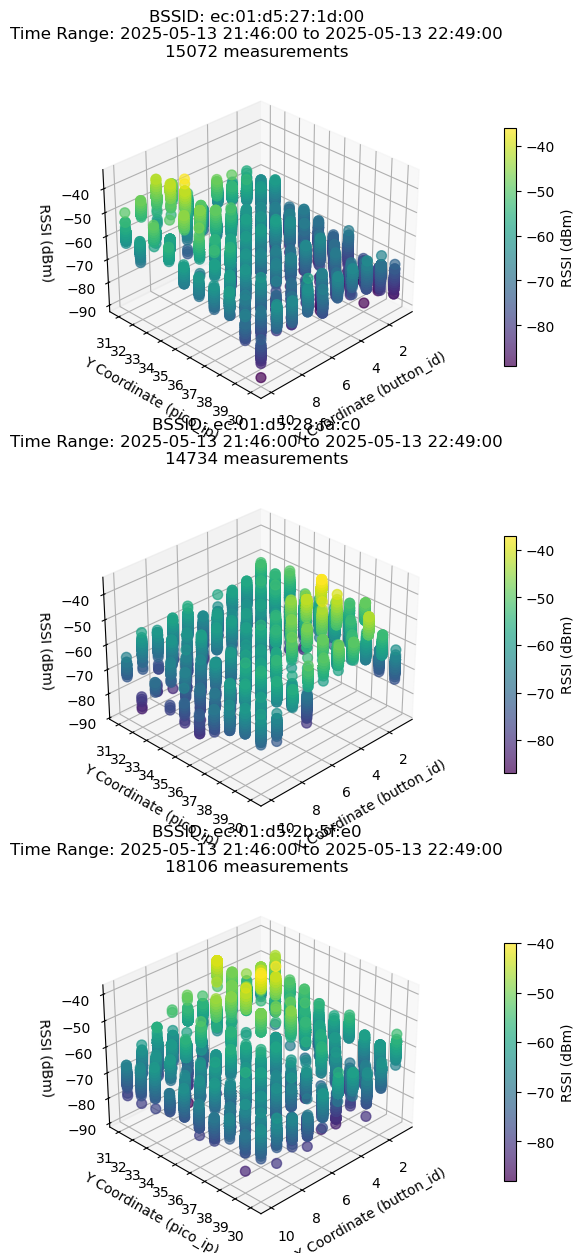

In [24]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np
from pymongo import MongoClient
from IPython.display import display, Markdown
from datetime import datetime


# Set time interval (UNIX timestamps)
start_time = datetime(2025, 5, 13, 21, 46).timestamp()  # Adjust start date
end_time = datetime(2025, 5, 13, 22, 49).timestamp()   # Adjust end date

# Define the custom order for pico IPs
custom_pico_order = [31, 32, 33, 34, 35, 36, 37, 38, 39, 30]
pico_mapping = {val: idx for idx, val in enumerate(custom_pico_order)}

# First get all unique fun_network BSSIDs in the time range
bssid_pipeline = [
    {
        "$match": {
            "timestamp": {"$gte": start_time, "$lte": end_time},
            "data.SSID": "fun_network"
        }
    },
    {"$unwind": "$data"},
    {"$match": {"data.SSID": "fun_network"}},
    {"$group": {"_id": "$data.BSSID"}},
    {"$sort": {"_id": 1}}
]

unique_bssids = [x["_id"] for x in collection.aggregate(bssid_pipeline)]

if not unique_bssids:
    display(Markdown("**No BSSIDs found in the specified time range**"))
else:
    display(Markdown(f"**Found {len(unique_bssids)} fun_network BSSIDs between " 
                   f"{datetime.fromtimestamp(start_time)} and {datetime.fromtimestamp(end_time)}**"))
    
    # Create a figure with subplots for each BSSID
    fig = plt.figure(figsize=(20, 5 * len(unique_bssids)))
    
    for i, bssid in enumerate(unique_bssids, 1):
        # Query for this specific BSSID
        pipeline = [
            {
                "$match": {
                    "timestamp": {"$gte": start_time, "$lte": end_time},
                    "data": {
                        "$elemMatch": {
                            "SSID": "fun_network",
                            "BSSID": bssid
                        }
                    }
                }
            },
            {
                "$addFields": {
                    "y_coordinate": {
                        "$toInt": {
                            "$arrayElemAt": [
                                {"$split": ["$metadata.pico_ip", "."]}, 
                                3
                            ]
                        }
                    },
                    "filtered_data": {
                        "$filter": {
                            "input": "$data",
                            "as": "item",
                            "cond": {
                                "$and": [
                                    {"$eq": ["$$item.SSID", "fun_network"]},
                                    {"$eq": ["$$item.BSSID", bssid]}
                                ]
                            }
                        }
                    }
                }
            },
            {"$unwind": "$filtered_data"},
            {
                "$project": {
                    "x": "$metadata.button_id",
                    "y": "$y_coordinate",
                    "z": "$filtered_data.RSSI",
                    "timestamp": 1,
                    "_id": 0
                }
            }
        ]
        
        data = list(collection.aggregate(pipeline))
        
        if not data:
            display(Markdown(f"No data found for BSSID: {bssid}"))
            continue
            
        df = pd.DataFrame(data)
        
        # Map Y coordinates to custom order positions
        df['y_mapped'] = df['y'].map(pico_mapping)
        
        # Add subplot for this BSSID
        ax = fig.add_subplot(len(unique_bssids), 1, i, projection='3d')
        
        # Plot the points
        scatter = ax.scatter(
            df['x'], 
            df['y_mapped'], 
            df['z'], 
            c=df['z'], 
            cmap='viridis', 
            s=50,
            alpha=0.7
        )
        
        # Set custom Y-axis ticks and labels
        ax.set_yticks(range(len(custom_pico_order)))
        ax.set_yticklabels(custom_pico_order)
        
        # Add labels and title
        ax.set_xlabel('X Coordinate (button_id)', fontsize=10)
        ax.set_ylabel('Y Coordinate (pico_ip)', fontsize=10)
        ax.set_zlabel('RSSI (dBm)', fontsize=10)
        ax.set_title(
            f'BSSID: {bssid}\n'
            f'Time Range: {datetime.fromtimestamp(start_time)} to {datetime.fromtimestamp(end_time)}\n'
            f'{len(df)} measurements',
            fontsize=12,
            pad=15
        )
        
        # Add colorbar
        cbar = fig.colorbar(scatter, ax=ax, shrink=0.7)
        cbar.set_label('RSSI (dBm)', fontsize=10)
        
        # Adjust view
        ax.view_init(30, 45)
        ax.grid(True, linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()